In [27]:
set = 'All'
balanced = True
passengers = False
trein = True
shallow = False
PCinfo = True

In [28]:
from fastai.tabular.all import *
import torch
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import clear_output, DisplayHandle
import os
from sklearn.utils import resample
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch
with open('../Odin/OdinData/odin-col-dict.json', "r") as json_file:
    choice_dict = json.load(json_file)

In [29]:
model_name = set
if passengers == True:
    model_name == '_passengers'
if balanced == True:
    model_name += '_balanced'
if trein == False:
    model_name += '_notrein'
if shallow == True:
    layers = [20, 10, 3]
else:
    layers = [200, 100, 20, 3]
    model_name += '_deep'
if PCinfo == True:
    model_name += 'PCinfo'

print(model_name)

All_balanced_deepPCinfo


In [30]:
dep_var = 'khvm'
cols = ['vertpc', 'aankpc', 'khvm', 'weekdag',
       'bike_dur', 'bike_dist', 'car_dur',
       'car_dist', 'pt_dur', 'pt_dist', 'walk_dur', 'walk_dist', 'sin_time', 'cos_time','choice_dur', 'choice_dist','oprijbewijsau'] #'hour'
if PCinfo == True:
    cols += ['aank Totaal', 'aank Man', 'aank Vrouw', 'aank tot 15 jaar',
       'aank 15 tot 25 jaar', 'aank 25 tot 45 jaar', 'aank 45 tot 65 jaar',
       'aank 65 jaar en ouder',
       'aank Geboren in Nederland met een Nederlandse herkomst',
       'aank Geboren in Nederland met een Europese herkomst (excl. Nederland)',
       'aank Geboren in Nederland met herkomst buiten Europa',
       'aank Geboren buiten Nederland met een Europese herkomst (excl. Nederland)',
       'aank Geboren buiten Nederland met een herkomst buiten Europa',
       'aank Totaal.1', 'aank Eenpersoons',
       'aank Meerpersoons \nzonder kinderen', 'aank Eenouder',
       'aank Tweeouder', 'aank Huishoudgrootte', 'aank Totaal.2',
       'aank voor 1945', 'aank 1945 tot 1965', 'aank 1965 tot 1975',
       'aank 1975 tot 1985', 'aank 1985 tot 1995', 'aank 1995 tot 2005',
       'aank 2005 tot 2015', 'aank 2015 en later', 'aank Meergezins',
       'aank Koopwoning', 'aank Huurwoning', 'aank Huurcoporatie',
       'aank Niet bewoond', 'aank WOZ-waarde\nwoning',
       'aank Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd',
       'aank density', 'vert Totaal', 'vert Man', 'vert Vrouw',
       'vert tot 15 jaar', 'vert 15 tot 25 jaar', 'vert 25 tot 45 jaar',
       'vert 45 tot 65 jaar', 'vert 65 jaar en ouder',
       'vert Geboren in Nederland met een Nederlandse herkomst',
       'vert Geboren in Nederland met een Europese herkomst (excl. Nederland)',
       'vert Geboren in Nederland met herkomst buiten Europa',
       'vert Geboren buiten Nederland met een Europese herkomst (excl. Nederland)',
       'vert Geboren buiten Nederland met een herkomst buiten Europa',
       'vert Totaal.1', 'vert Eenpersoons',
       'vert Meerpersoons \nzonder kinderen', 'vert Eenouder',
       'vert Tweeouder', 'vert Huishoudgrootte', 'vert Totaal.2',
       'vert voor 1945', 'vert 1945 tot 1965', 'vert 1965 tot 1975',
       'vert 1975 tot 1985', 'vert 1985 tot 1995', 'vert 1995 tot 2005',
       'vert 2005 tot 2015', 'vert 2015 en later', 'vert Meergezins',
       'vert Koopwoning', 'vert Huurwoning', 'vert Huurcoporatie',
       'vert Niet bewoond', 'vert WOZ-waarde\nwoning',
       'vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd',
       'vert density']
rawdf = pd.read_pickle('../Odin/Odin2019' + set)[cols]
print(len(rawdf))

192071


In [31]:
#POSTCODE RESTRICTIONS TO SIMPLIFY EMBEDDING MATRIX
#
# aavc = rawdf.aankpc.value_counts()
# vevc = rawdf.vertpc.value_counts()
# i = aavc[aavc > 5].index
# i2 = vevc[vevc > 5].index
#
# df = rawdf[rawdf.aankpc.isin(i) & rawdf.vertpc.isin(i2)]

In [32]:
df = rawdf

if trein == False:
    df[dep_var] = df[dep_var].replace('Trein', 'Bus/tram/metro')
df[dep_var].unique()

df[dep_var].replace('Personenauto - passagier', 'Personenauto - bestuurder', inplace = True)
print(len(df))

df = df[df[dep_var] != 'Overig']

192071


In [33]:
def balance_multiclass(df, target_col):
    # Find out which class has the most entries
    max_size = df[target_col].value_counts().min()

    dfs = []

    for class_name, group in df.groupby(target_col):
        # For each group, randomly oversample with replacement to the size of the largest group
        df_group_resampled = resample(group, replace=False, n_samples= min(int(max_size * 1.2), len(group)), random_state=123)
        dfs.append(df_group_resampled)

    # Concatenate all groups and return
    return pd.concat(dfs, axis=0)
if balanced == True:
    df = balance_multiclass(df, 'khvm')

len(df)

41881

In [34]:
df.head()

,vertpc,aankpc,khvm,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,...,vert 2005 tot 2015,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density
6174,1053,1068,Bus/tram/metro,Vrijdag,1269.0,4909.99,978.0,5158.41,1387.0,5422.613050,...,0.007750,0.023794,0.609413,0.000363,0.000302,0.245415,0.018881,0.000121,0.104559,1.000000
40329,9711,9733,Bus/tram/metro,Woensdag,1204.0,5223.00,1129.0,6163.00,1444.0,7377.000000,...,0.009039,0.041087,0.516271,0.000203,0.000654,0.165089,0.024427,0.000116,0.070538,0.539073
84122,6811,6833,Bus/tram/metro,Vrijdag,685.0,2967.00,685.0,2967.00,1257.0,4368.000000,...,0.025473,0.037529,0.607019,0.000602,0.000860,0.127772,0.018587,0.000165,0.105860,0.304381
50237,1092,1054,Bus/tram/metro,Zaterdag,1157.0,4519.19,981.0,4530.19,1664.0,4904.423116,...,0.001574,0.017903,0.518872,0.000675,0.000562,0.269283,0.015499,0.000249,0.115479,0.699804
107605,3011,2902,Bus/tram/metro,Zondag,1873.0,7568.96,1186.0,8145.71,1679.0,8001.600724,...,0.074431,0.019578,0.521502,0.000333,0.000277,0.103482,0.016007,0.000097,0.077169,0.550944


In [35]:
dep_var = 'khvm'
cat_names = list(df.select_dtypes(include=['object']).columns)
cont_names = [x for x in cols if x not in cat_names]
cat_names.remove(dep_var)

procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.3)(range_of(df))
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var,
                   splits = splits, y_block = CategoryBlock())
dls = to.dataloaders(bs=64, splits=splits)
# learn = tabular_learner(dls, layers=layers, metrics=accuracy)
learn = tabular_learner(dls, layers = layers, metrics=accuracy)

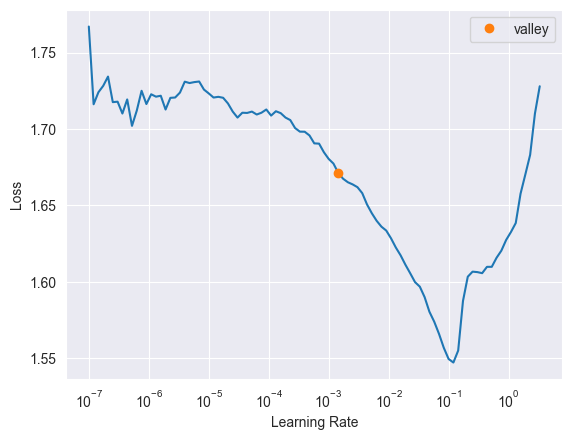

In [36]:
lr = learn.lr_find()

In [39]:
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.900411,0.991845,0.000000,00:39
1,0.783459,0.909303,0.000000,00:31


In [41]:
os.makedirs(os.path.join('models', model_name), exist_ok = True)
learn.export(os.path.join('models', model_name, 'model.pkl'))
# learn = load_learner(os.path.join('ModelNames', model_name, 'model.pkl'))

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                           precision    recall  f1-score   support

           Bus/tram/metro       0.61      0.71      0.66       788
                    Fiets       0.51      0.46      0.48       928
Personenauto - bestuurder       0.64      0.71      0.67       924
                  Te voet       0.72      0.53      0.61       775
                    Trein       0.77      0.83      0.80       773

                 accuracy                           0.64      4188
                macro avg       0.65      0.65      0.64      4188
             weighted avg       0.64      0.64      0.64      4188



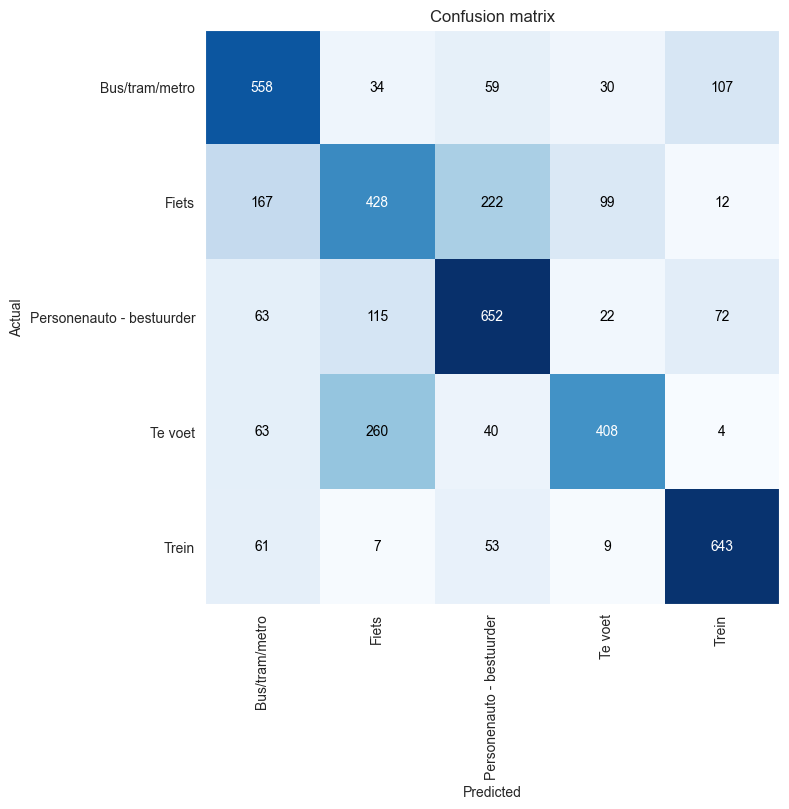

In [42]:
interp.plot_confusion_matrix(figsize=(8,8))

In [43]:
test_df = pd.read_pickle('../FelyxData/felyxotp')
test_df['choice_dist'] = test_df['distancemoved'] * 100000
test_df['choice_dur'] = test_df['timedelta'].dt.seconds
test_cols = [col for col in cols if col != dep_var]
test_df = test_df[test_cols]
# test_df.drop([''], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

preds, _ = learn.get_preds(dl=dl)#, with_decoded=True)
preds = preds.argmax(dim=-1)
test_df['pred'] = [dl.vocab[pred] for pred in preds]
test_df.groupby('pred').count()

,vertpc,aankpc,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,...,vert 2005 tot 2015,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density
pred,,,,,,,,,,,,,,,,,,,,,
Bus/tram/metro,7158,7158,7158,7158,7158,7158,7158,7158,7158,7158,...,7158,7158,7158,7158,7158,7158,7158,7158,7158,7158
Fiets,2881,2881,2881,2881,2881,2881,2881,2881,2881,2881,...,2881,2881,2881,2881,2881,2881,2881,2881,2881,2881
Personenauto - bestuurder,866,866,866,866,866,866,866,866,866,866,...,866,866,866,866,866,866,866,866,866,866
Te voet,7396,7396,7396,7396,7396,7396,7396,7396,7396,7396,...,7396,7396,7396,7396,7396,7396,7396,7396,7396,7396
Trein,164,164,164,164,164,164,164,164,164,164,...,164,164,164,164,164,164,164,164,164,164


In [44]:
dl = learn.dls.test_dl(df)

preds, _ = learn.get_preds(dl=dl)#, with_decoded=True)
preds = preds.argmax(dim=-1)
df['pred'] = [dl.vocab[pred] for pred in preds]
df.groupby('pred').count()

,vertpc,aankpc,khvm,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,...,vert 2005 tot 2015,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density
pred,,,,,,,,,,,,,,,,,,,,,
Bus/tram/metro,9136,9136,9136,9136,9136,9136,9136,9136,9136,9136,...,9136,9136,9136,9136,9136,9136,9136,9136,9136,9136
Fiets,8462,8462,8462,8462,8462,8462,8462,8462,8462,8462,...,8462,8462,8462,8462,8462,8462,8462,8462,8462,8462
Personenauto - bestuurder,9889,9889,9889,9889,9889,9889,9889,9889,9889,9889,...,9889,9889,9889,9889,9889,9889,9889,9889,9889,9889
Te voet,5906,5906,5906,5906,5906,5906,5906,5906,5906,5906,...,5906,5906,5906,5906,5906,5906,5906,5906,5906,5906
Trein,8488,8488,8488,8488,8488,8488,8488,8488,8488,8488,...,8488,8488,8488,8488,8488,8488,8488,8488,8488,8488


In [55]:
learn.model.layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=308, out_features=200, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=200, out_features=100, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=100, out_features=20, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): LinBnDrop(
    (0): Linear(in_features=20, out_features=3, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): LinBnDrop(
    (0): Linear(in_features=3, out_features=5, bias=True)
  )
)

In [47]:
# Pass the test DataLoader through the trained model
hook = hook_output(learn.model.layers[-2])

hactslist = []

for i in [df, test_df]:
    dl = learn.dls.test_dl(i)

    all = []

    for batch in dl:
        # print(batch)
        b = (batch[0].to('mps:0'), batch[1].to('mps:0'))
        with torch.no_grad():
            learn.model.eval()
            _ = learn.model(*b)

        activations = hook.stored
        all.append(activations)

    hacts = np.concatenate([a.cpu() for a in all], axis=0)
    hactslist.append(hacts)

combinedhacts = np.concatenate(hactslist)
combinedhacts.shape

(60346, 3)

In [52]:
n_components = 3
combined = pd.concat([df, test_df])
combined['train'] = (([1] * len(df)) + ([0] * len(test_df)))
combined['choice'] = pd.concat([combined[combined.khvm.notnull()].khvm, combined[combined.train == 0].pred])

combined[['Emb' + str(i) for i in range(n_components)]] = combinedhacts#np.concatenate([trainhacts, testhacts])

combined.to_pickle(os.path.join('models', model_name, 'predictions'))
combined.head()

In [59]:
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, [pd.DataFrame(data = em, index = i) for i, em in zip(indices,embedding_matrices)]))

with open(os.path.join('models', model_name, 'embedding_dictionary'), 'wb') as f:
    pickle.dump(categ_dictionary, f)

print(categ_dictionary.keys())

dict_keys(['vertpc', 'aankpc', 'weekdag', 'oprijbewijsau'])


In [ ]:
n_components = 3
pca = PCA(n_components=n_components)
redu = pca.fit_transform(np.concatenate([trainhacts, testhacts]))

combined[['PCA' + str(i) for i in range(n_components)]] = redu

In [56]:
# show = combined[combined.train == 1].sample(100)
combined = pd.concat([combined[combined.train == x].sample(5000) for x in [0,1]])

In [57]:
show = pd.concat([combined[combined.choice == x].sample(20) for x in combined.choice.unique()])

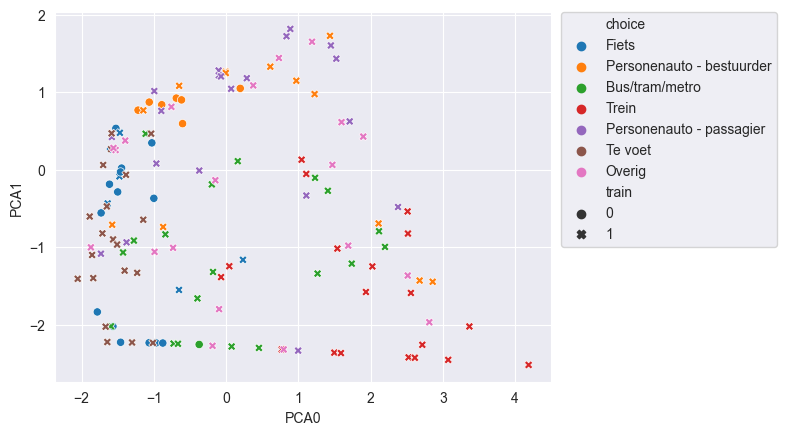

In [52]:
#2D option
sns.scatterplot(data = show, x = 'PCA0', y= 'PCA1', hue = 'choice', style = 'train')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_9739/1045855428.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(show['choice'].unique()))


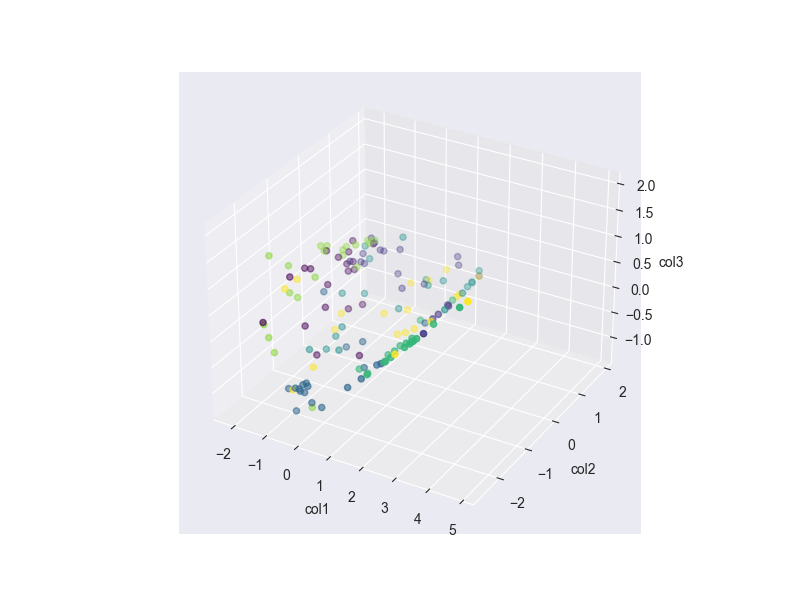

In [76]:
#3D Option
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm
colormap = cm.get_cmap('viridis', len(show['choice'].unique()))
color_dict = {category: colormap(i) for i, category in enumerate(show['choice'].unique())}

ax.scatter(show['PCA0'], show['PCA1'], show['PCA2'], c=show.choice.map(color_dict), marker='o')

ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')
plt.show()

In [48]:
#Create a Dicitonary containing the embedding matrix for every categorical variable
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, embedding_matrices))
for i in categ_dictionary.keys():
    print(i, ': ', categ_dictionary[i].shape)

vertpc :  (1477, 95)
aankpc :  (1460, 95)
weekdag :  (8, 5)
hour :  (25, 10)


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


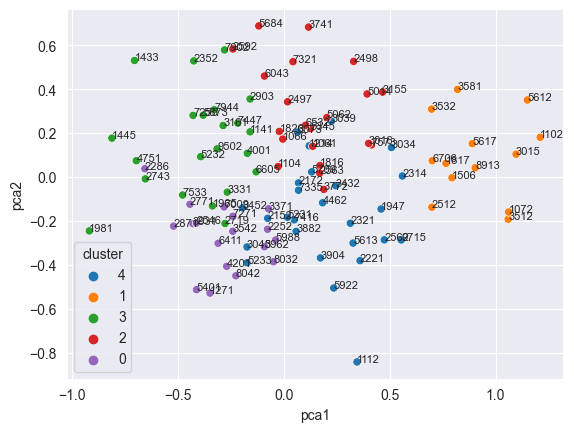

In [45]:
lablength = 10
categ = 'aankpc'
embedding_matrix = categ_dictionary[categ]
labels = learn.dls.classes[categ]

k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding_matrix)
# Give it the category name if the info is in the JSON
if categ in choice_dict.keys():
    labels = [choice_dict[categ].get(item, item)[:lablength] for item in [str(lab) for lab in labels]]
else:
    labels = [str(lab)[:lablength] for lab in labels]
pca = PCA(n_components=2)
mat_2d = pca.fit_transform(embedding_matrix)

PlotData = pd.DataFrame({'pca1': mat_2d[1:, 0], 'pca2': mat_2d[1:, 1],
                       categ: labels[1:], 'cluster':[str(x) for x in kmeans.labels_[1:]]})

if len(PlotData) > 100:
    PlotData = PlotData.sample(100)

sns.scatterplot(data = PlotData, x = 'pca1', y = 'pca2', hue = 'cluster')

for i in PlotData.index:
    plt.text(PlotData.pca1.loc[i], PlotData.pca2.loc[i], PlotData[categ][i], fontsize=8)